# NCAR EdEc Bootcamp, Boosting / Bagging (Day 2, 9:10 AM)

Supervised learning using decision trees

Great paper here: https://arxiv.org/pdf/2207.08815.pdf

And Here: https://arxiv.org/pdf/2106.03253.pdf

on XGBoost

CatBoost paper here: https://arxiv.org/pdf/1706.09516.pdf

## Python Imports

In [1]:
import pandas as pd
import numpy as np
import time


# Plotting
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Machine Learning
import sklearn
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, max_error
from sklearn.feature_selection import RFE

import xgboost as xgb
from xgboost import XGBRegressor

import catboost as cat
from catboost import CatBoostRegressor

In [2]:
import ipywidgets as widgets
from IPython.display import display

In [3]:
print('scikit-learn version:', sklearn.__version__)
print('XGBoost version:', xgb.__version__)
print('Catboost version:', cat.__version__)

scikit-learn version: 1.3.0
XGBoost version: 2.0.0
Catboost version: 1.2.1.1.16484


## Dataset Loading

We will be using this open source dataset to go through some ML workflow tasks:

https://essd.copernicus.org/articles/13/3013/2021/

In [4]:
df = pd.read_csv('http://hdl.handle.net/11304/89dd440e-4e10-496e-b476-1ccf0ebeb4f3')
df.head(3)

,id,country,htap_region,climatic_zone,lon,lat,alt,relative_alt,type,type_of_area,...,o3_perc90,o3_perc98,o3_dma8eu,o3_avgdma8epax,o3_drmdmax1h,o3_w90,o3_aot40,o3_nvgt070,o3_nvgt100,dataset
0,3336,Germany,EUR,cool_moist,8.308210,54.924970,12.0,3,background,rural,...,46.4399,54.8468,53.5738,38.8078,50.7704,86.1266,10197.4742,2.0,0.0,test
1,3338,Germany,EUR,cool_moist,12.725280,54.436670,1.0,1,background,rural,...,44.0575,53.7778,51.3996,35.8313,48.3935,69.0987,7573.2222,1.0,0.0,train
2,3339,Germany,EUR,cool_moist,6.093923,50.754704,205.0,66,background,urban,...,41.1803,58.4009,54.9030,32.6169,49.8276,154.1263,8655.4730,5.4,1.0,train


In [5]:
missing_values = df.isna().sum()
print(missing_values)

id                                         0
country                                    0
htap_region                                0
climatic_zone                              0
lon                                        0
lat                                        0
alt                                        0
relative_alt                               0
type                                       0
type_of_area                               0
water_25km                                 0
evergreen_needleleaf_forest_25km           0
evergreen_broadleaf_forest_25km            0
deciduous_needleleaf_forest_25km           0
deciduous_broadleaf_forest_25km            0
mixed_forest_25km                          0
closed_shrublands_25km                     0
open_shrublands_25km                       0
woody_savannas_25km                        0
savannas_25km                              0
grasslands_25km                            0
permanent_wetlands_25km                    0
croplands_

In [6]:
df.replace(-999.0, np.nan, inplace=True)
df.describe()

,id,lon,lat,alt,relative_alt,water_25km,evergreen_needleleaf_forest_25km,evergreen_broadleaf_forest_25km,deciduous_needleleaf_forest_25km,deciduous_broadleaf_forest_25km,...,o3_perc75,o3_perc90,o3_perc98,o3_dma8eu,o3_avgdma8epax,o3_drmdmax1h,o3_w90,o3_aot40,o3_nvgt070,o3_nvgt100
count,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,5577.000000,...,4447.000000,4447.000000,4447.000000,4564.000000,4552.000000,5545.000000,4490.000000,4461.000000,4552.000000,4490.000000
mean,11481.604447,13.477650,39.302449,264.636320,49.784113,12.667886,2.884884,0.511655,0.002241,2.676529,...,37.172352,47.175823,60.833433,58.179091,37.913457,54.235095,162.541878,16344.881654,8.628496,1.522356
std,4041.144957,88.079720,13.233924,466.298427,107.169033,19.386709,9.199527,4.170122,0.080375,9.027644,...,6.338292,7.048452,9.582222,9.168651,6.401068,8.273298,115.034771,10262.296344,11.904406,3.986506
min,3336.000000,-170.564000,-89.996000,-4.000000,-136.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,11.528500,16.326400,22.139100,20.367200,10.704800,16.587600,1.345800,0.000000,0.000000,0.000000
25%,8252.000000,-76.003333,35.411100,20.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,33.397200,42.804600,55.548150,53.021775,33.684925,49.465000,77.992025,8943.194800,1.000000,0.000000
50%,11732.000000,7.478586,39.834461,90.000000,21.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,37.258800,47.600000,60.800000,58.425000,38.279000,54.289200,131.530600,14984.790500,4.250000,0.000000
75%,15431.000000,127.115140,45.836945,287.000000,47.000000,23.400000,1.600000,0.000000,0.000000,0.000000,...,41.000000,52.000000,66.800000,64.075800,42.132050,58.667500,224.705125,22369.884200,12.000000,1.000000
max,17722.000000,174.870000,82.450830,5500.000000,1826.000000,100.000000,96.400000,99.500000,4.800000,94.500000,...,61.640000,74.872000,115.286000,108.077500,71.186100,102.152200,738.478400,72430.871300,179.500000,93.000000


In [7]:
missing_values2 = df.isna().sum()
print(missing_values2)

id                                            0
country                                       0
htap_region                                   0
climatic_zone                                 0
lon                                           0
lat                                           0
alt                                           0
relative_alt                                  0
type                                          0
type_of_area                                  0
water_25km                                    0
evergreen_needleleaf_forest_25km              0
evergreen_broadleaf_forest_25km               0
deciduous_needleleaf_forest_25km              0
deciduous_broadleaf_forest_25km               0
mixed_forest_25km                             0
closed_shrublands_25km                        0
open_shrublands_25km                          0
woody_savannas_25km                           0
savannas_25km                                 0
grasslands_25km                         

In [8]:
df.dropna(axis=1, inplace=True)
df.shape

(5577, 39)

# Theory (9:15)

## Decision Trees

A decision tree is a machine learning model that uses a tree-like structure to make predictions. The tree is constructed by recursively partitioning the data into smaller and smaller subsets, based on the values of the features. Each node in the tree represents a question about a feature, and the branches represent the different possible answers. The leaf nodes of the tree represent the predictions.

To make a prediction, the model starts at the root node of the tree and asks the question associated with that node. Based on the answer, the model follows the corresponding branch to the next node. The process continues until the model reaches a leaf node, which contains the prediction.

## Boosting vs Bagging

Boosting and bagging are both ensemble learning methods, which means that they combine multiple machine learning models to improve performance. However, they work in different ways.

__Boosting__ works by training a sequence of models, where each model is trained on the errors of the previous model. This means that the models are able to learn from each other and improve their performance over time. Boosting algorithms are typically more accurate than bagging algorithms, but they can also be more complex and slower to train.

__Bagging__ works by training multiple models on different subsets of the data. The predictions of the models are then averaged to produce the final prediction. Bagging algorithms are typically less accurate than boosting algorithms, but they are also simpler to implement and faster to train.

Examples of boosting algorithms:

- XGBoost
- CatBoost

Examples of bagging algorithms:

- Random Forest


Good StatQuest video [here](https://www.youtube.com/watch?app=desktop&v=3CC4N4z3GJc)

## Scaling your data

No, you do not need to scale your data when doing XGBoost or other decision tree methods like CatBoost. In fact, scaling can actually make your model perform worse.

Decision tree methods work by splitting the feature space into smaller and smaller regions, based on the values of the features. The splits are chosen to maximize the purity of the regions, meaning that they should contain as many examples of the same class as possible.

Scaling the features does not change the underlying data distribution, so it will not affect the way that the decision tree splits the feature space. However, it can make it more difficult for the tree to learn the correct splits, especially if the features are scaled to very different ranges.

For example, if you have a feature that represents the price of a house, and you scale it to the range 0 to 1, the decision tree will be forced to make splits at arbitrary points in the price range, even if there are no natural breaks in the data. This can lead to a less accurate model.

There are a few exceptions to this rule. For example, if you are using a decision tree method for classification, and you have a target variable that is imbalanced (meaning that there are many more examples of one class than the other), you may want to scale your data to try to improve the performance of the model.

# Model Comparison (9:25):

In [9]:
df_floats = df.select_dtypes(include=['float'])
df_floats 

,lon,lat,alt,water_25km,evergreen_needleleaf_forest_25km,evergreen_broadleaf_forest_25km,deciduous_needleleaf_forest_25km,deciduous_broadleaf_forest_25km,mixed_forest_25km,closed_shrublands_25km,...,urban_and_built-up_25km,cropland-natural_vegetation_mosaic_25km,snow_and_ice_25km,barren_or_sparsely_vegetated_25km,wheat_production,rice_production,nox_emissions,no2_column,nightlight_5km,o3_average_values
0,8.308210,54.924970,12.0,86.1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.1,0.0,0.0,0.000000,0.0,0.672115,2.270,20.73000,33.4050
1,12.725280,54.436670,1.0,55.7,1.2,0.0,0.0,0.0,8.7,0.0,...,0.0,8.3,0.0,0.0,1.380000,0.0,0.093612,2.310,6.38000,29.8555
2,6.093923,50.754704,205.0,0.0,1.9,0.0,0.0,0.0,32.8,0.0,...,16.5,29.2,0.0,0.0,0.959000,0.0,4.941520,7.060,46.87000,23.8597
3,8.548389,52.023169,102.0,0.0,0.0,0.0,0.0,0.0,11.4,0.0,...,16.4,32.5,0.0,0.0,2.332000,0.0,14.142200,5.230,54.30000,20.3253
4,6.874554,51.862000,45.0,0.0,0.0,0.0,0.0,0.0,18.5,0.0,...,9.8,55.4,0.0,0.0,2.954000,0.0,2.209770,7.990,24.14000,21.4072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5572,11.027920,49.322730,344.0,0.0,7.8,0.0,0.0,0.0,40.7,0.0,...,15.8,22.6,0.0,0.0,0.838361,0.0,5.914120,4.570,29.19580,18.7670
5573,11.850274,52.602056,35.0,0.0,8.1,0.0,0.0,0.0,14.8,0.0,...,2.4,22.7,0.0,0.0,7.322900,0.0,1.896920,3.160,23.37090,26.3113
5574,11.091078,51.456071,143.0,0.0,0.0,0.0,0.0,1.6,26.4,0.0,...,3.2,16.4,0.0,0.0,8.712890,0.0,1.653200,3.205,7.64238,23.5591
5575,13.420573,48.947611,858.0,0.0,15.7,0.0,0.0,0.0,54.2,0.0,...,1.0,26.1,0.0,0.0,0.037776,0.0,0.356192,2.090,5.41958,35.6457


In [10]:
df_floats = df_floats.drop(columns=['lon','lat'])

In [11]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(df_floats .drop('o3_average_values', axis=1), df_floats ['o3_average_values'], test_size=0.2, random_state=42)

In [12]:
# Create the models
models = {
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'CatBoost': CatBoostRegressor(),
    'XGBoost': XGBRegressor()
}

# Create a new Pandas DataFrame with four columns
df_results = pd.DataFrame(columns=['Decision Tree', 'Random Forest', 'CatBoost', 'XGBoost'])

# Train the models and time the training process
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = {}
for model_name, model in models.items():
    y_pred[model_name] = model.predict(X_test)
    df_results[model_name] = y_pred[model_name]

# Calculate the RMSE and max error for each model
rmse = {}
max_err = {}
for model_name, y_pred in y_pred.items():
    rmse[model_name] = mean_squared_error(y_test, y_pred, squared=False)
    max_err[model_name] = max_error(y_test, y_pred)

Learning rate set to 0.051855
0:	learn: 6.2740213	total: 59.4ms	remaining: 59.3s
1:	learn: 6.1798841	total: 60.6ms	remaining: 30.3s
2:	learn: 6.0884213	total: 62.1ms	remaining: 20.6s
3:	learn: 5.9970073	total: 63.6ms	remaining: 15.8s
4:	learn: 5.9115050	total: 64.8ms	remaining: 12.9s
5:	learn: 5.8382316	total: 66.1ms	remaining: 11s
6:	learn: 5.7649600	total: 67.3ms	remaining: 9.55s
7:	learn: 5.6961530	total: 68.6ms	remaining: 8.51s
8:	learn: 5.6270331	total: 69.9ms	remaining: 7.69s
9:	learn: 5.5660420	total: 71ms	remaining: 7.03s
10:	learn: 5.5116213	total: 72.3ms	remaining: 6.5s
11:	learn: 5.4633830	total: 73.4ms	remaining: 6.04s
12:	learn: 5.4126179	total: 74.4ms	remaining: 5.65s
13:	learn: 5.3582951	total: 75.7ms	remaining: 5.33s
14:	learn: 5.3042882	total: 76.8ms	remaining: 5.04s
15:	learn: 5.2567428	total: 77.9ms	remaining: 4.79s
16:	learn: 5.2190994	total: 79ms	remaining: 4.57s
17:	learn: 5.1746233	total: 80ms	remaining: 4.36s
18:	learn: 5.1390153	total: 81ms	remaining: 4.18s
19:

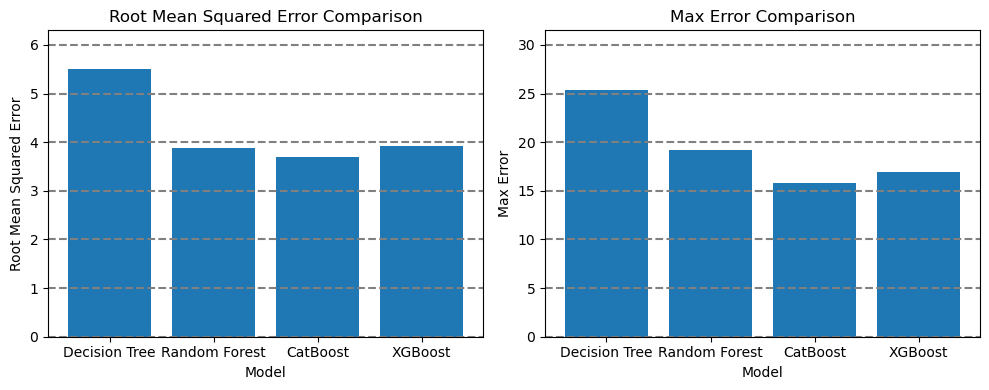

In [13]:
fig = plt.figure(figsize=(10, 4))

# Create the subplots
ax1 = plt.subplot(1, 2, 1)
ax2 = plt.subplot(1, 2, 2)

# Plot the RMSE bar chart
ax1.bar(models.keys(), rmse.values(), zorder=1)
ax1.set_xlabel('Model')
ax1.set_ylabel('Root Mean Squared Error')
ax1.set_title('Root Mean Squared Error Comparison')

# Plot the max error bar chart
ax2.bar(models.keys(), max_err.values(), zorder=1)
ax2.set_xlabel('Model')
ax2.set_ylabel('Max Error')
ax2.set_title('Max Error Comparison')

# Draw horizontal grid lines for both subplots
for tick in ax1.get_yticks():
    ax1.axhline(tick, color='gray', linestyle='--', zorder=2)

for tick in ax2.get_yticks():
    ax2.axhline(tick, color='gray', linestyle='--', zorder=2)

# Adjust the subplot layout
plt.tight_layout()

# Show the plot
plt.show()

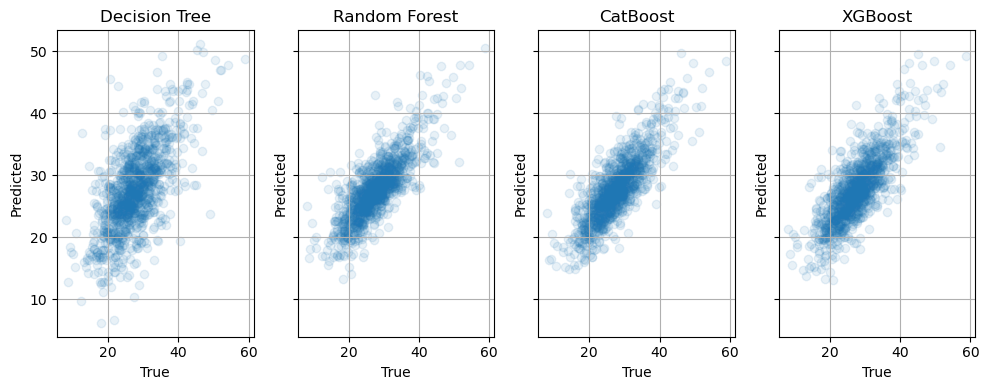

In [14]:

# Create the figure and subplots
fig, axes = plt.subplots(1, 4, figsize=(10, 4), sharey=True)

# Plot the scatter plots
axes[0].scatter(y_test, df_results['Decision Tree'], alpha=0.1)
axes[1].scatter(y_test, df_results['Random Forest'], alpha=0.1)
axes[2].scatter(y_test, df_results['CatBoost'], alpha=0.1)
axes[3].scatter(y_test, df_results['XGBoost'], alpha=0.1)

# Add labels and titles to the subplots
axes[0].set_xlabel('True')
axes[0].set_ylabel('Predicted')
axes[0].set_title('Decision Tree')
axes[1].set_xlabel('True')
axes[1].set_ylabel('Predicted')
axes[1].set_title('Random Forest')
axes[2].set_xlabel('True')
axes[2].set_ylabel('Predicted')
axes[2].set_title('CatBoost')
axes[3].set_xlabel('True')
axes[3].set_ylabel('Predicted')
axes[3].set_title('XGBoost')

# Add a grid to all subplots
for ax in axes:
    ax.grid(True)

# Tighten the layout of the figure
fig.tight_layout()

# Display the plot
plt.show()

#### Follow up questions:

- What model would you choose?
- Easy to figure out which is the best model?
- Are these results more similar or different?
- Did any of the models require extra lines of code?

# Parameters Check (9:35)

__Depth__: The depth of a decision tree is the length of the longest path from the root node to a leaf node. It essentially measures how deep the tree goes in terms of decision-making levels. The root node is considered to be at depth 0, and each level deeper adds 1 to the depth.

__Impact on Model Complexity__: The depth of a decision tree is a crucial hyperparameter that can significantly affect the model's complexity and performance. Deeper trees are more complex and can capture intricate patterns in the data but may be prone to overfitting, meaning they fit the training data too closely and perform poorly on unseen data. Shallower trees are simpler and less prone to overfitting but may not capture complex patterns in the data as effectively.

__Tuning Depth__: In practice, you can control the depth of a decision tree by setting hyperparameters like "max_depth" or "min_samples_split" during the model training process. Adjusting these hyperparameters allows you to strike a balance between model complexity and generalization to achieve better performance on unseen data.

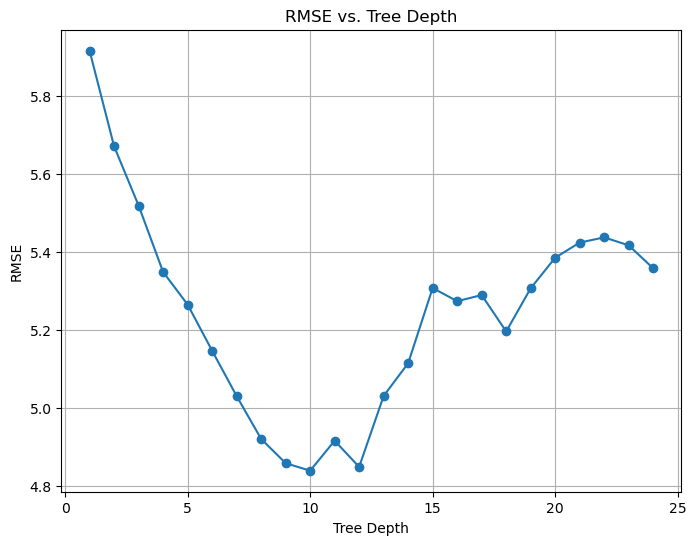

In [15]:
# Initialize variables to store RMSE values
depths = range(1, 25)  # Test depths from 1 to 10
rmse_values = []

# Loop over different tree depths
for depth in depths:
    # Create a Decision Tree Regressor with the specified depth
    tree_regressor = DecisionTreeRegressor(max_depth=depth, random_state=42)
    
    # Fit the model on the training data
    tree_regressor.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = tree_regressor.predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    
    # Append RMSE to the list
    rmse_values.append(rmse)

# Plot RMSE values for different depths
plt.figure(figsize=(8, 6))
plt.plot(depths, rmse_values, marker='o', linestyle='-')
plt.title('RMSE vs. Tree Depth')
plt.xlabel('Tree Depth')
plt.ylabel('RMSE')
plt.grid(True)
plt.show()

## Feature Importance in XGBoost (9:40)

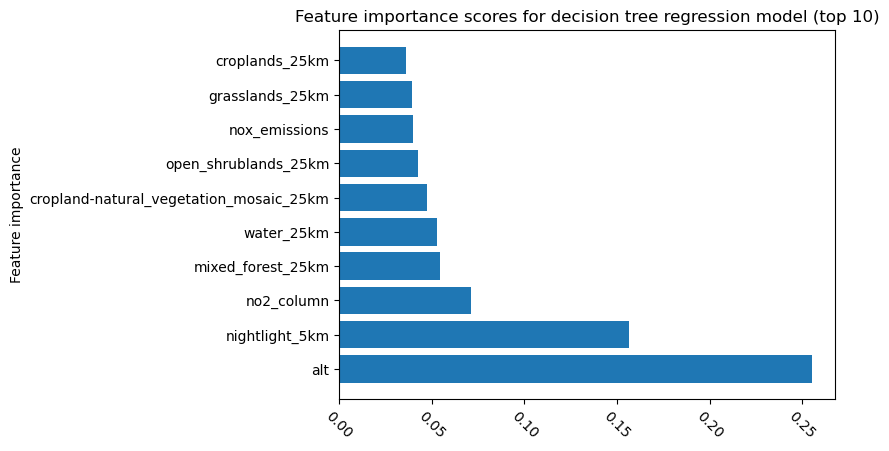

In [16]:
# Train a decision tree regression model
model = DecisionTreeRegressor()
model.fit(X_train, y_train)

# Calculate the feature importance scores
feature_importances = model.feature_importances_

# Sort the feature importance scores in order of importance
sorted_feature_importances = np.argsort(feature_importances)[::-1]

# Get the feature names
feature_names = df_floats.columns

# Slice the feature names and feature importance scores to the top 10 elements
top_10_feature_names = feature_names[sorted_feature_importances[:10]]
top_10_feature_importances = feature_importances[sorted_feature_importances[:10]]

# Plot the feature importance scores for the top 10 features
plt.barh(top_10_feature_names, top_10_feature_importances)
plt.ylabel("Feature importance")
plt.title("Feature importance scores for decision tree regression model (top 10)")

plt.xticks(rotation=-45, x=np.arange(len(top_10_feature_names)) + 1.75)

plt.show()


## Recursive Feature Elimation (9:50)

Recursive feature elimination (RFE) is a feature selection technique that works by recursively removing features from a dataset until a desired number of features remain. It is a sequential feature selection method, which means that it removes features one at a time.

RFE works by first training a model on the full dataset. Then, it ranks the features based on their importance to the model. The least important feature is then removed from the dataset, and the model is retrained on the remaining features. This process is repeated until the desired number of features remain.

RFE is a popular feature selection technique because it is simple to implement and can be used with a variety of machine learning models. It is also a relatively efficient technique, as it only needs to train the model once for each feature.

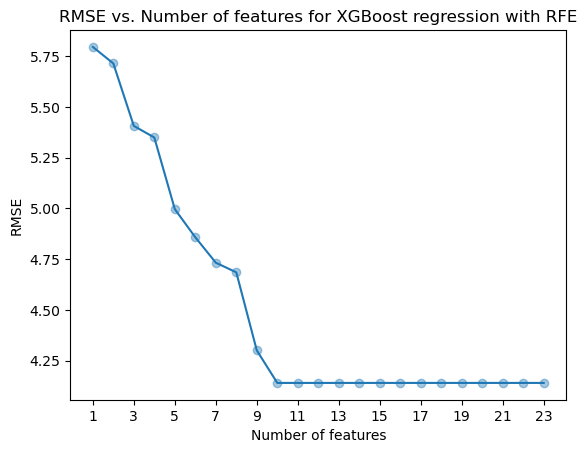

In [17]:
# Create an XGBoost regressor
model = XGBRegressor()

# Create an RFE object
rfe = RFE(estimator=model, n_features_to_select=10)

# Fit the RFE object to the training data
rfe.fit(X_train, y_train)

# Get the selected features
selected_features = rfe.get_support(indices=True)

# Train a new XGBoost regressor on the selected features
model = XGBRegressor()
model.fit(X_train.iloc[:, selected_features], y_train)

# Evaluate the model on the testing set
y_pred = model.predict(X_test.iloc[:, selected_features])
mse = mean_squared_error(y_test, y_pred, squared=True)

# Calculate the RMSE for different number of features
n_features = range(1, X_train.shape[1] + 1)
rmses = []
for n in n_features:
    selected_features = rfe.get_support(indices=True)[:n]
    model = XGBRegressor()
    model.fit(X_train.iloc[:, selected_features], y_train)
    y_pred = model.predict(X_test.iloc[:, selected_features])
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmses.append(rmse)

# Plot the RMSE vs. number of features
plt.plot(n_features, rmses)
plt.scatter(n_features, rmses, alpha=0.4)
plt.xlabel('Number of features')
plt.ylabel('RMSE')
plt.title('RMSE vs. Number of features for XGBoost regression with RFE')

# Set the x axis to every 2
plt.xticks(range(1, X_train.shape[1] + 1, 2))
plt.show()

## Categorical Variables (10:00)


One-hot encoding is a popular technique for representing categorical data in machine learning. It works by creating a new binary variable for each category in the original variable. For example, if the original variable has three categories (red, green, and blue), then one-hot encoding will create three new variables: is_red, is_green, and is_blue. Each row in the data will then have a value of 1 in one of these new variables, and 0 in the other two.

While one-hot encoding is a simple and effective technique, it has some downsides:

- __Increased dimensionality__: One-hot encoding can significantly increase the dimensionality of the data, especially if there are many categories in the original variable. This can make the model more complex and slower to train.
- __Sparse data__: One-hot encoded data is typically very sparse, meaning that most of the values in the new variables will be 0. This can make it difficult for some machine learning algorithms to learn from the data.
- __Overfitting__: One-hot encoding can also lead to overfitting, especially if there are many categories in the original variable and the sample size is relatively small.

### CatBoost categorical variables


CatBoost is a gradient boosting algorithm that is specifically designed to handle categorical features. It does not require one-hot encoding because it uses a technique called CatBoost encoding.

CatBoost encoding works by creating a separate representation for each category in a categorical feature. This representation is based on the target variable, and it is updated as the model is trained. This allows CatBoost to learn the relationship between the categorical features and the target variable without having to one-hot encode the data.

We will use the original dataframe with categorical features:

In [18]:
df.columns

Index(['id', 'country', 'htap_region', 'climatic_zone', 'lon', 'lat', 'alt',
       'relative_alt', 'type', 'type_of_area', 'water_25km',
       'evergreen_needleleaf_forest_25km', 'evergreen_broadleaf_forest_25km',
       'deciduous_needleleaf_forest_25km', 'deciduous_broadleaf_forest_25km',
       'mixed_forest_25km', 'closed_shrublands_25km', 'open_shrublands_25km',
       'woody_savannas_25km', 'savannas_25km', 'grasslands_25km',
       'permanent_wetlands_25km', 'croplands_25km', 'urban_and_built-up_25km',
       'cropland-natural_vegetation_mosaic_25km', 'snow_and_ice_25km',
       'barren_or_sparsely_vegetated_25km', 'wheat_production',
       'rice_production', 'nox_emissions', 'no2_column', 'population_density',
       'max_population_density_5km', 'max_population_density_25km',
       'nightlight_1km', 'nightlight_5km', 'max_nightlight_25km',
       'o3_average_values', 'dataset'],
      dtype='object')

In [19]:
df_for_cat = df.drop(columns=['id', 'lat', 'lon', 'dataset'])

In [20]:
# Split the data into training and test sets
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(df_for_cat.drop('o3_average_values', axis=1), df_for_cat['o3_average_values'], test_size=0.2, random_state=42)

In [21]:
# Identify categorical columns
categorical_columns = df_for_cat.select_dtypes(include=['object']).columns.tolist()

# Initialize the CatBoost Regressor
model = CatBoostRegressor(iterations=500, depth=6, learning_rate=0.1)

In [22]:
# Train the model
model.fit(X_train_cat, y_train_cat, cat_features=categorical_columns)

0:	learn: 6.1364596	total: 4.08ms	remaining: 2.03s
1:	learn: 5.9412420	total: 7.62ms	remaining: 1.9s
2:	learn: 5.7405741	total: 10.6ms	remaining: 1.75s
3:	learn: 5.5695283	total: 14.2ms	remaining: 1.76s
4:	learn: 5.4087343	total: 17.6ms	remaining: 1.74s
5:	learn: 5.2682943	total: 20.7ms	remaining: 1.71s
6:	learn: 5.1470404	total: 23.7ms	remaining: 1.67s
7:	learn: 5.0369983	total: 26.6ms	remaining: 1.64s
8:	learn: 4.9303647	total: 29.6ms	remaining: 1.61s
9:	learn: 4.8192224	total: 32.8ms	remaining: 1.61s
10:	learn: 4.7302891	total: 35.7ms	remaining: 1.59s
11:	learn: 4.6433150	total: 38.7ms	remaining: 1.57s
12:	learn: 4.5620545	total: 41.3ms	remaining: 1.55s
13:	learn: 4.4849106	total: 44ms	remaining: 1.53s
14:	learn: 4.4301776	total: 46.9ms	remaining: 1.52s
15:	learn: 4.3771019	total: 49.6ms	remaining: 1.5s
16:	learn: 4.3186095	total: 52.3ms	remaining: 1.49s
17:	learn: 4.2626396	total: 55.2ms	remaining: 1.48s
18:	learn: 4.2089323	total: 58.2ms	remaining: 1.47s
19:	learn: 4.1631627	total

In [23]:
# Make predictions
predictions = model.predict(X_test_cat)

In [24]:
rmse = np.sqrt(mean_squared_error(y_test_cat, predictions))
print(f'Root Mean Squared Error (RMSE): {rmse:.2f}')

Root Mean Squared Error (RMSE): 3.28


Is this RMSE better than the model(s) above? 

In [25]:
# Get feature importances
feature_importance = model.get_feature_importance()

# Create a DataFrame to store feature names and their importances
feature_importance_df = pd.DataFrame({'Feature': X_train_cat.columns, 'Importance': feature_importance})

# Sort the DataFrame by importance and select the top 5 features
top5_features = feature_importance_df.sort_values(by='Importance', ascending=False).head(8)

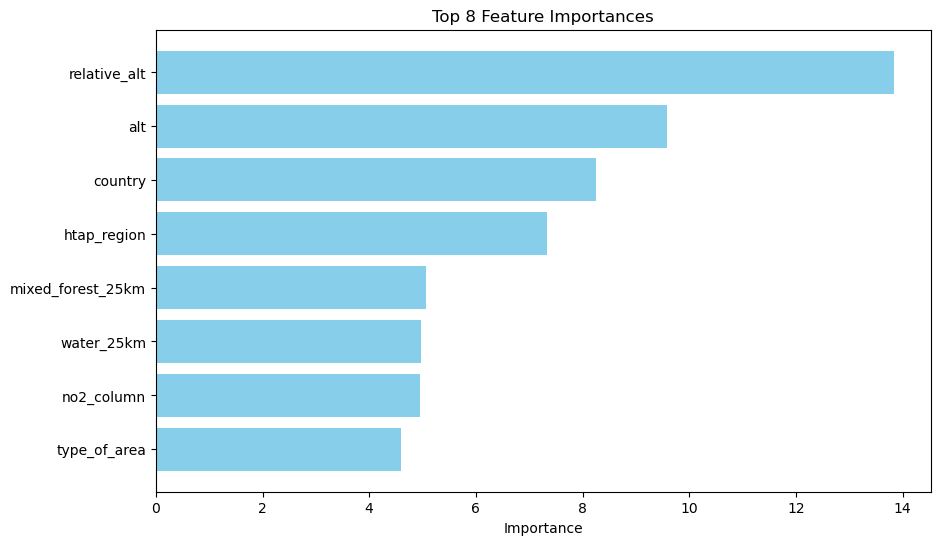

In [26]:
# Plot the top 8 feature importances
plt.figure(figsize=(10, 6))
plt.barh(top5_features['Feature'], top5_features['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.title('Top 8 Feature Importances')
plt.gca().invert_yaxis()
plt.show()

Feature Importance Calculation: To calculate feature importance, CatBoost follows these steps:

For each feature in your dataset, CatBoost temporarily shuffles the values of that feature in the validation (or test) dataset while keeping the other features intact.

It then evaluates the model's performance using the validation dataset with this one feature's values shuffled. This results in a decrease in model performance because the feature's information has been randomized.

The difference between the baseline performance (from step 2) and the performance with the shuffled feature represents how important that feature is. If shuffling a particular feature has a significant negative impact on model performance, that feature is considered more important.

CatBoost repeats this process for all features in your dataset, one at a time, to compute their importance scores.

# Quick Summary (10:10)

CatBoost, XGBoost, and Random Forest are popular machine learning algorithms for classification and regression tasks.

CatBoost, short for "Categorical Boosting," is designed to handle categorical features efficiently. It automatically encodes categorical data and uses a gradient boosting framework. It excels in predictive accuracy, handles missing values well, and has robust out-of-the-box performance.

XGBoost, or "Extreme Gradient Boosting," is another gradient boosting algorithm known for its speed and scalability. It offers fine-tuning options, regularization techniques, and supports custom loss functions. XGBoost often delivers excellent performance on structured datasets and is favored for its flexibility.

Random Forest is an ensemble method that combines multiple decision trees to make predictions. It's straightforward to use, resistant to overfitting, and can handle various data types. While it may not achieve the same predictive accuracy as CatBoost or XGBoost in some cases, it is computationally efficient and a good choice for many problems.

In summary, CatBoost is ideal for datasets with categorical features, XGBoost offers flexibility and speed, and Random Forest is a reliable and efficient choice for a wide range of applications. The choice between them depends on the specific requirements and characteristics of your data and problem.

# Discussion (10:15)

## Things I would (generally) not use tree based models for:

- Image recgonition/classification problems
- 3D data / normal gridded data (think climate model output)
- super clean / synethetic data 
- simple problems (use day 1 options!)

## Further Work / Discussion topics:

- If you scale the dataset, does it improve metrics? 
- What are some potential downside of tree models?
- Are tree models easy to interpret? 
- Any scaling issues with these types of models?

# Break at 10:30! See you back at 10:40